In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import h5py
import sys
import os
import glob
import warnings
import matplotlib.pyplot as plt

from tqdm import tqdm

warnings.filterwarnings('ignore')

In [3]:
from morphogenesis.decomposition.decomposition_model import LeftRightSymmetrize

with h5py.File('../02.LearnDynamicsModel/myosin_fitting.h5', 'r') as h5f:
    data = h5f['ensemble']
    tmin, tmax = -10, 20
    
    t = data['fields/v'].attrs['t']
    t_mask = np.logical_and(t >= tmin, t <= tmax)
    m0 = data['fields/m_ij'][t_mask, ...][()]
    s0 = data['fields/c'][t_mask, ...][()]
    v0 = data['fields/v'][t_mask, ...][()]
    t0 = t[t_mask, ...][()]
    
m0 = LeftRightSymmetrize().fit_transform(m0.reshape([-1, 4, 236, 200]))
v0 = LeftRightSymmetrize().fit_transform(v0.reshape([-1, 2, 236, 200]))
s0 = LeftRightSymmetrize().fit_transform(s0.reshape([-1, 1, 236, 200]))

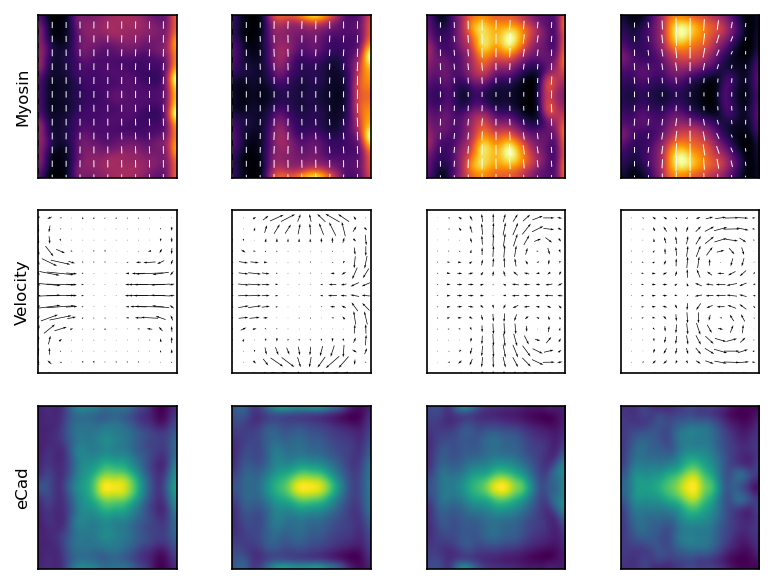

In [4]:
from morphogenesis.plot_utils import *
fig, ax = plt.subplots(3, 4, dpi=150)

for i in range(4):
    plot_tensor(ax[0, i], m0[10*i])
    plot_vector(ax[1, i], v0[10*i], skip=16)
    plot_scalar(ax[2, i], s0[10*i])

ax[0,0].set_ylabel('Myosin')
ax[1,0].set_ylabel('Velocity')
ax[2,0].set_ylabel('eCad')
for a in ax.flatten():
    a.set(ylim=[dv_min, dv_max])

(31, 2, 2, 236, 200, 2) (31, 2, 236, 200, 2) (31, 1, 1, 236, 200)
(31, 2, 2, 236, 200) (31, 2, 2, 236, 200)


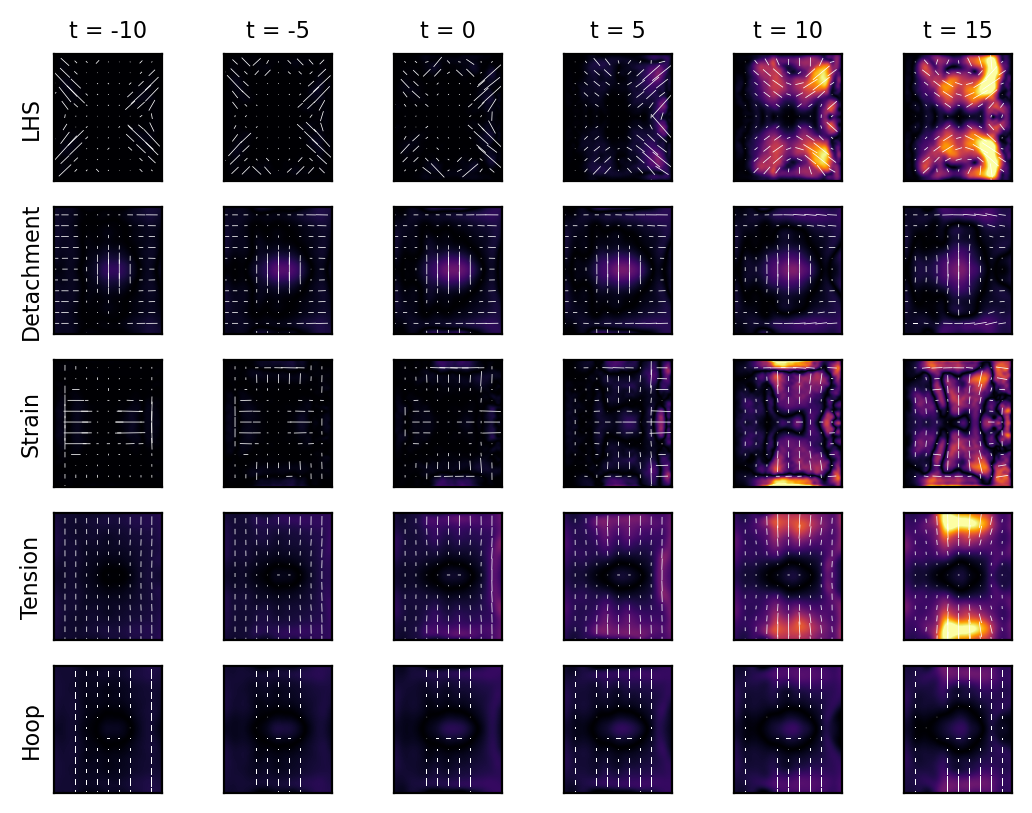

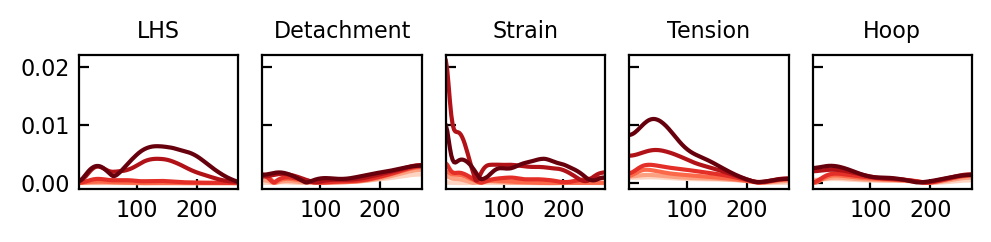

In [59]:
from morphogenesis.forecasting.transforms import *
from morphogenesis.plot_utils import *

gradient = EmbryoGradient(dv_mode='circular', sigma=3).fit(m0)
m0 = m0.reshape([-1, 2, 2, 236, 200])
s0 = s0.reshape([-1, 1, 1, 236, 200])
d1_m = gradient.transform(m0.reshape([-1, 2, 2, 236, 200]))
d1_v = gradient.transform(v0.reshape([-1, 2, 236, 200]))

print(d1_m.shape, d1_v.shape, s0.shape)

O = -0.5 * (np.einsum('biyxj->bijyx', d1_v) - \
            np.einsum('biyxj->bjiyx', d1_v))
E =  0.5 * (np.einsum('biyxj->bijyx', d1_v) + \
            np.einsum('biyxj->bjiyx', d1_v))

print(O.shape, E.shape)

#Myosin dynamics - comoving derivative
lhs  =	np.einsum('bkyx,bijyxk->bijyx', v0, d1_m)
lhs +=	np.einsum('bikyx,bkjyx->bijyx', O, m0)
lhs -=	np.einsum('bikyx,bkjyx->bijyx', m0, O)

trm = np.einsum('bkkyx->byx', m0)[:, None, None]
trE = np.einsum('bkkyx->byx', E)[:, None, None]
gamma_dv = np.array([[1, 0], [0, 0]])[:, :, None, None]

detach  = -(0.066 - 0.061 * s0) * m0 #Detachment
strain  =  (0.489 + 0.318 * s0) * m0 * trE #Strain recruitment
tension =  (0.564 - 0.393 * s0) * trm * m0 #Tension recruitment
hoop    =  (0.047 - 0.037 * s0) * trm * gamma_dv #Hoop stress recruitment

fig, ax = plt.subplots(5, 6, dpi=200, sharey='col')
fig2, ax2 = plt.subplots(1, 5, dpi=200, sharey=True, figsize=(5, 1.25))

kwargs = dict(vmin=0, vmax=0.01)
dt = 5

dv = np.linspace(dv_min, dv_max, 236)

for i in range(ax.shape[1]):
    plot_tensor(ax[0, i], -lhs[dt*i], **kwargs)
    plot_tensor(ax[1, i], detach[dt*i], **kwargs)
    plot_tensor(ax[2, i], strain[dt*i], **kwargs)
    plot_tensor(ax[3, i], tension[dt*i], **kwargs)
    plot_tensor(ax[4, i], hoop[dt*i], **kwargs)

    color = plt.cm.Reds(((i+1)*dt)/(ax.shape[1]*dt))
    slc = np.s_[dt*i, :, :, :, 80:120]
    ax2[0].plot(dv, np.mean(np.linalg.norm(lhs[slc], axis=(0,1)), axis=-1), color=color)
    ax2[1].plot(dv, np.mean(np.linalg.norm(detach[slc], axis=(0,1)), axis=-1), color=color)
    ax2[2].plot(dv, np.mean(np.linalg.norm(strain[slc], axis=(0,1)), axis=-1), color=color)
    ax2[3].plot(dv, np.mean(np.linalg.norm(tension[slc], axis=(0,1)), axis=-1), color=color)
    ax2[4].plot(dv, np.mean(np.linalg.norm(hoop[slc], axis=(0,1)), axis=-1), color=color)

    ax[0, i].set_title(f't = {-10 + dt*i}')

ax[0,0].set_ylabel('LHS')
ax[1,0].set_ylabel('Detachment')
ax[2,0].set_ylabel('Strain')
ax[3,0].set_ylabel('Tension')
ax[4,0].set_ylabel('Hoop')
for a in ax.flatten():
    a.set(ylim=[dv_min, dv_max])

ax2[0].set_title('LHS')
ax2[1].set_title('Detachment')
ax2[2].set_title('Strain')
ax2[3].set_title('Tension')
ax2[4].set_title('Hoop')
for a in ax2:
    a.set(xlim=[dv_min, dv_midpoint])

plt.tight_layout()